# Recurrent Neural Network

**RNNs** are deep learning models that capture the dynamics of sequences via *recurrent* connections (cycles in the network of nodes). They have advantages of flexibility in handling data of varying length and the ability to make sequential predictions useful for NLP, time-series analysis and video analysis.

Conventional machine learning models have concerned with single feature vector $x\in\mathbb{R^d}$ of fixed length $d$. RNN and relevant ideas are capable of processing sequence of data, namely an ordered list of feature vectors, $x_1, ..., x_T$, where each feature vector $x_i$ is indexed with a time step $t\in \mathbb{Z}^+$. 

Though the entire sample data is drawn from a hypothetical distribution, we do not assume that adjacent feature vectors are independent from each other. Model type varies based on the actual structure of the observations and targetes. **Aligned** model make a prediction for each input, while **unaligned** model may predict a sequence of target from one input or one target for a sequence of data. 

##  Autoregressive Model
Given the historical data $x_1,..,x_{t-1}$, we are interested in $P(x_t|x_1,...,x_{t-1})$. We may focus on the summary statistics $E[P(x_t|x_1,...,x_{t-1})]$. Based on the belif of unneccessity to trace back the history to far, we define some $\tau\in \mathbb{Z}^+$ and focus on $x_{t-\tau}, ...,x_{t-1}$. The model also creates some latent summary statistics $h_t$ of the past observations. Then,$\hat x_t = P(x_t | h_t)$ and $h_t = g(h_{t-1}, x_{t-1})$.

## Sequence Model

When working with discrete data, we wish to estimate the joint probability of an entire sequence. Sequence model is identical to the autoregressive model since
$$
P(x_1,...X_T) = P(x_1)\prod^T_{t=2}P(x_t|x_{t-1},...,x_1)
$$


## Markov Model

Whenever keeping only recent data in time $\tau$ does lose predictive power, we say that the sequence satisfies a *Markov coondition*, and call it $\tau$-th order Markov model. Then, a markov model is a simplified sequence model.

## Markov Model Example:

### Generate Sine Curve

This notebook aims to build a model that models sine curve by using local information along (independent from the time).

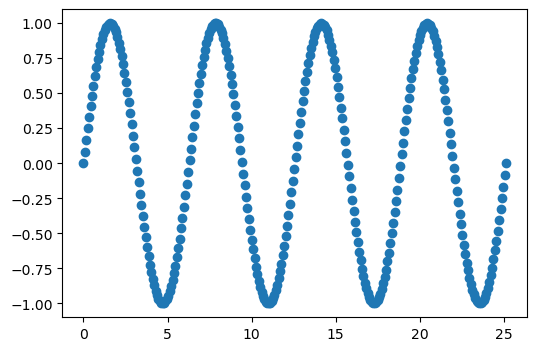

In [1]:
import torch
import dl
import matplotlib.pyplot as plt
import numpy as np

TAU = 4
class CosineData(dl.DataModule):
    def __init__(self, batch_size=32, T=300, num_train=250, tau=4):
        self.save_hyperparameters()
        self.time = np.linspace(0, 8*np.pi, T)
        self.x = torch.sin(torch.tensor(self.time))

    def get_dataloader(self, train=True):
        if train:
            indices = list(range(0, self.num_train-self.tau-1, 1))
        else:
            indices = list(range(self.num_train, self.time.shape[0]-self.tau-1, 1))

        yield (
            torch.stack([self.x[offset:indices[-1]+offset] for offset in range(self.tau)], dim=1),
            self.x[self.tau:indices[-1]+self.tau].reshape(-1, 1)
        )

data = CosineData(tau=TAU)
plt.scatter(data.time, data.x);

### Markov Model

Define a simple linear regression model that depends on the previous P time steps.

In [2]:
class LinearRegression(dl.Module):
    def __init__(self, P, eta, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Linear(P, 1, dtype=torch.float64)

    def init_params(self):
        for p in self.net.parameters():
            torch.init.normal_(p, mean=0, std=self.sigma)

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2
        return l.mean()

### Plot the loss

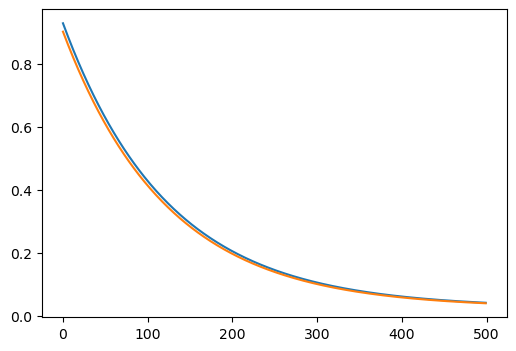

In [3]:
trainer = dl.Trainer(500)
model = LinearRegression(TAU, 0.001)
trainer.fit(model, data)
trainer.plot_loss()

### Intrapolation

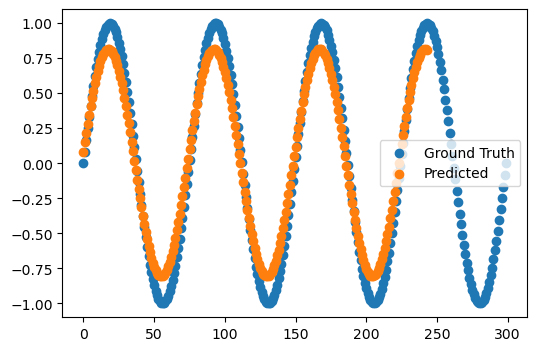

In [4]:
plt.scatter(range(len(data.x)), data.x)
x_hat = torch.concat([model(X) for X,y in data.get_dataloader()]).detach().numpy().flatten()
plt.scatter(range(len(x_hat)), x_hat)
plt.legend(['Ground Truth', 'Predicted'])

Thus, a simple linear regression fit the noisy training cosine curve reasonably well although it also fit the noise. Now we observe how it generalizes to the unseen data. Notice that the model relies on $x$ to predict $\hat x$. Thus, the technique for making successive prediction is
$$\hat x_t = f(\hat x_{t-\tau-1}, ...,\hat x_{t-1})$$

### Extrapolation

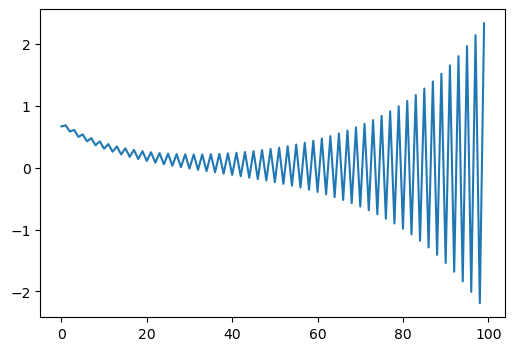

In [5]:
x = torch.tensor(x_hat[-TAU:]).reshape(1,-1)
x_hat_future = []
for n in range(100):
    output = model(x)
    x_hat_future.append(output.item())
    x = torch.tensor(list(x.numpy()[0])[-TAU+1:] + [output.item()]).reshape(1,-1)
plt.plot(range(len(x_hat_future)), x_hat_future);

Observe that without input data, the model is capable of capturing the overall trend. The dramatic deviation from the actual curve is due to the accumulation of error terms as $T$ grows.

## MLP Model

In [21]:
class MLP(dl.Module):

    def __init__(self, input_size, hidden_size=10, eta=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, self.hidden_size, dtype=torch.float64),
            torch.nn.Linear(self.hidden_size, 1, dtype=torch.float64)
        )

        for var in self.parameters():
            torch.nn.init.normal_(var, std=0.01)
    
    def loss(self, y_hat, y):
        loss = torch.nn.MSELoss()
        return loss(y_hat, y)

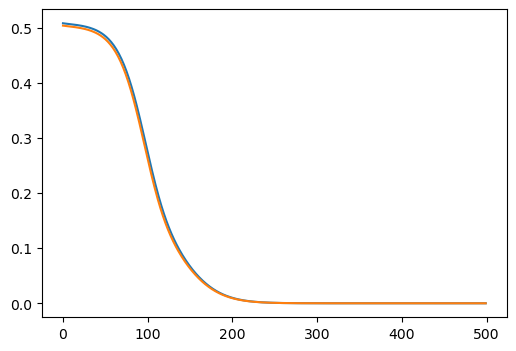

In [37]:
TAU = 20
data = CosineData(tau=TAU)
trainer = dl.Trainer(500)
model = MLP(TAU)
trainer.fit(model, data)
trainer.plot_loss()

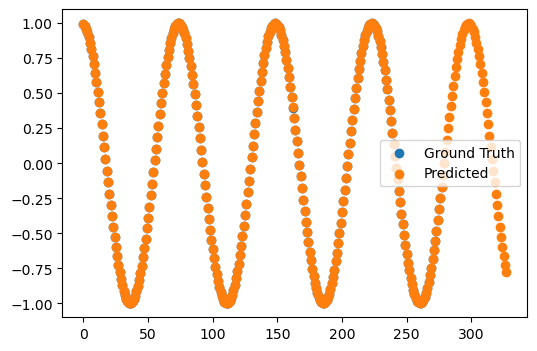

In [40]:
with torch.no_grad():
    plt.scatter(range(len(data.x[TAU:])), data.x[TAU:])
    x_hat = torch.concat([model(X) for X,y in data.get_dataloader()]).detach().numpy().flatten()
    x_new = []
    input = torch.tensor(x_hat[-TAU:])
    for _ in range(100):
        new = model(input)
        input[:-1] = input[1:].clone()
        input[-1] = new
        x_new.append(new.item())
    x_hat = list(x_hat) + x_new
    plt.scatter(range(len(x_hat)), x_hat)
    plt.legend(['Ground Truth', 'Predicted'])

A MLP with identity activation function can achieve equally good result in modeling certain functions. 

See 
- https://ai.stackexchange.com/questions/36488/entirely-linear-neural-network-learning-non-linear-function/36489#36489
- https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave/notebook

## Recurrent Neural Network

Recurrent neural network refers to layer that feed in a summary information of previous observations to make the current prediction. At time step $t$, the network maintains a fixed function to compute the hidden state $h_t$. For a minibatch examples $X\in\mathbb{R}^{n\times d}$, the hidden layer output $H\in\mathbb{R}^{n\times h}$ is calculated as 
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
$$
Next, using the hidden state, we can make prediction by
$$
O_t = H_tW_{hq} + b_q
$$
similar to regular MLP.

**Remark**: The calculation of $X_tW_{xh} + H_{t-1}W_{hh}$ is equivalent to $ concat(X_t, H_{t-1}) \times concat(W_{xh}, W_{hh})$. (not proven)

**Remark**: In order to exploit the full potential of the hidden states, an entire sequence should be fed into the model. RNN would fail to extrapolate if trained on a segment of the sequence.

In [58]:
import torch.nn as nn

@dl.add_to_class(CosineData)
def get_dataloader(self):
    yield self.x[:self.num_train-1].view(-1, 1, 1), self.x[1:self.num_train].view(-1,1,1)

class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # we randomly initialize our trainable parameters
        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size, dtype=torch.float64))
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size, dtype=torch.float64))

        self.b = torch.nn.Parameter(torch.randn(hidden_size, dtype=torch.float64))

    def forward(self, x_t, state):

        h_prev = state

        a = x_t @ self.U + h_prev @ self.W + self.b
        h = torch.sigmoid(a)

        return h
    
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        # This is our missing equation from before, 
        # in Torch the feed-forward layers are called Linear
        self.linear = nn.Linear(hidden_size, 1, dtype=torch.float64) 

    def init_hidden(self,):
        # we will initialize our hidden state with zeros
        return torch.zeros(1,self.hidden_size, dtype=torch.float64) 
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:

            self.h = self.rnn_cell.forward(X_t, self.h)

            y_t = self.linear.forward(self.h)
            outputs.append(y_t)

        return torch.stack(outputs), self.h

### Training

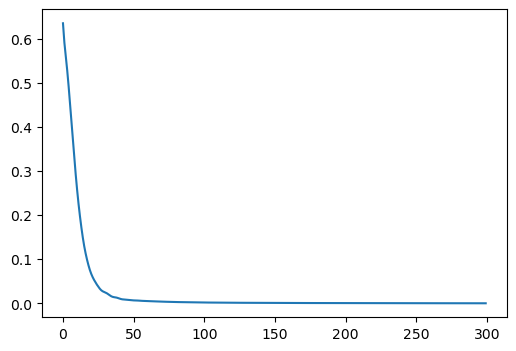

In [61]:
model = RNN(1, 20)
optim = torch.optim.Adam(model.parameters(), 0.01)
loss = torch.nn.MSELoss()
data = CosineData(num_train=180)

losses = []
for epoch in range(300):
    optim.zero_grad()
    x, y = next(data.get_dataloader())
    y_hat, _ = model(x)
    l = loss(y_hat, y)
    l.backward()
    optim.step()
    losses.append(l.item())

plt.plot(losses);  

### Intrapolation & Extrapolation

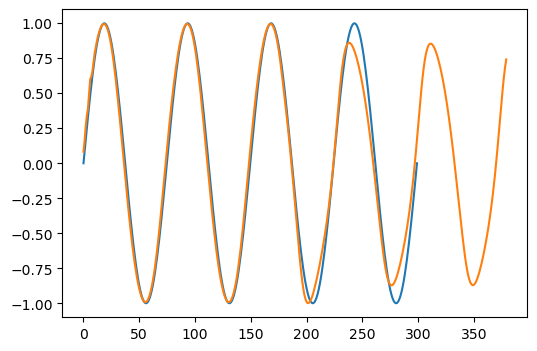

In [62]:
with torch.no_grad():
    predicted_x, state = model(data.x[:data.num_train].reshape(-1, 1, 1))
    predicted_x = predicted_x.flatten()

    real_x = data.x
    future_x = []
    x = predicted_x[-1].reshape(-1,1,1)
    for i in range(200):
        x, state = model(x, state)
        future_x.append(x.item())

plt.plot(real_x)
plt.plot(list(predicted_x) + future_x);

As the result above suggests, a depth-2 recurrent neural network is able to fit a sine function and maintain a good extrapolation accuracy, which outperforms a simple regression model. 

## Backpropagation Through Time

The architecture of RNN introduces the depth to the network in the temporal sense. The hidden state is a recursive function of the recurrent layer.
$$
h_t = f(o''_t) = f(x_tW_{xh} + h_{t-1}W_{hh} + b_h) \\
o_t = g(o'_t) = g(h_tW_{hq} + b_q)
$$
The loss at time $T$ is dependent on $H_{T-1}$ and is thus affected by weights multiple times. The SGD algorithm needs to compute $\frac{\partial L}{\partial W_{xh}}$, $\frac{\partial L}{\partial W_{hh}}$, and $\frac{\partial L}{\partial W_{hq}}$.

Reacll that 
$$
L = \frac{1}{T}\sum^T_{t=1}l(o_t, y_t)
$$
Then,
$$
\frac{\partial L}{\partial o_t} = \frac{\partial l}{T \cdot \partial o_t}
$$
Applying the chain rule,
$$
\frac{\partial L}{\partial W_{hq}} = \sum^T_{t=1}\frac{\partial L}{\partial o_t}\frac{\partial g}{\partial o'_t}h^T_t\\

\frac{\partial L}{\partial W_{xh}} = \sum^T_{t=1}\frac{\partial L}{\partial h_t}\frac{\partial f}{\partial o''_t}x^T_t\\

\frac{\partial L}{\partial W_{hh}} = \sum^T_{t=1}\frac{\partial L}{\partial h_t}\frac{\partial f}{\partial o''_t}h^T_{t-1}
$$

The last step is to compute $\frac{\partial L}{\partial h_t}$,

$$
\frac{\partial L}{\partial h_t}=\frac{\partial L}{\partial h_{t+1}}\frac{\partial f}{\partial o''_{t+1}}\frac{\partial o''_{t+1}}{\partial h_t} + \frac{\partial L}{\partial o_t}\frac{\partial g}{\partial o'_t}\frac{\partial o'_t}{\partial h_t} = \frac{\partial L}{\partial h_{t+1}}\frac{\partial f}{\partial o''_{t+1}}W^T_{hh} + \frac{\partial L}{\partial o_t}\frac{\partial g}{\partial o'_t}W^T_{qh}
$$

For symplicity, we let the activation function be identity functio for now. Expanding the recurrent computation yields,

$$
\frac{\partial L}{\partial h_t} = \sum^T_{i=t}(W^T_{hh})^{T-i}W^T_{qh}\frac{\partial L}{\partial o_{T+t-i}}
$$

The power of $W^T_{hh}$ is potentially numerical unstable, causing exploding gradient or vanishing gradient. 
 

### Truncating Time Steps

One way to avoid numerical instability issue is to simply truncate the recursive series and approximate the true gradient. That is for some $\tau$ we compute the gradient up to $\frac{\partial h_{t-\tau}}{\partial w_h}$. In practice, it works somewhat well because the model assumes dependence on the near past.

### Gradient Clipping

Gradient clipping is a heuristic method to prevent exploding gradient. Simply put, the algorithm restricts the maximum $L^2$ norm of the gradient by computing
$$
g = min(1, \frac{\theta}{||g||_2})g
$$
while leaving the learning rate unchanged.

### Randomized Truncation

We can replaced $\frac{\partial h_t}{\partial w_h}$ by a random variable which is correct in expectation. 